In [2]:
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

In [3]:


#importing all needed libraries and packages

import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline



ModuleNotFoundError: No module named 'keras'

In [14]:
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [15]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [16]:
#defining relative paths from root directory of this python notebook

train_path = 'train'
valid_path = 'validation'
test_path = 'test'

In [17]:
#getting training,validation and testing data

train_batches = ImageDataGenerator().flow_from_directory(train_path,color_mode = 'grayscale', target_size=(24,24), class_mode = 'binary', batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,color_mode = 'grayscale', target_size=(24,24), class_mode = 'binary', batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,color_mode = 'grayscale', target_size=(24,24), class_mode = 'binary', batch_size=10,shuffle = True )

Found 11327 images belonging to 2 classes.
Found 2190 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


In [18]:
color_train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(100,100), class_mode = 'binary', batch_size=10)

#plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Found 11327 images belonging to 2 classes.


In [19]:
imgs, labels = next(color_train_batches)

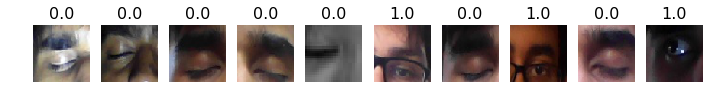

In [20]:
plots(imgs , titles = labels)

In [21]:
def makeModel():
    model = Sequential()
    #this model was inspired by the VGG 16 model that won the image net competition I have used a similar pattern of layers
    #this model is lighter and made for just this implementation. 
    
    #model architecture is as follows
    
    #Input==>Conv(16) X 2 ==>Conv(32) X 2==> maxpool==> Conv(64) X 3 
    #     ==>maxpool ==> Conv(128) x 3 ==>unroll==>FC(256) X 3 ==>sigmoid(1)
    
    #other than output layer the other activations are RectifiedLinearUnits
    batch_size =256
    lr = 0.003
 
    model.add(Conv2D(16, (3,3), padding = 'same',
                   input_shape=(24,24,1)))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (2,2), padding= 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (2,2), padding= 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
 
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(256))
    
    
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
   
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
 
    
    model.compile(optimizer=SGD(lr=lr, decay = lr/batch_size), 
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
 
    return model

In [22]:
model = makeModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 24, 24, 16)        160       
_________________________________________________________________
activation_15 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
activation_16 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        2080      
__________

In [23]:
history = model.fit_generator(train_batches,steps_per_epoch = 70,validation_data=valid_batches, epochs=200, verbose =1)
#history = model.fit_generator(train_batches,validation_data=valid_batches, epochs=50, verbose =1)

Epoch 1/200
70/70 [==============================] - 11s 160ms/step - loss: 0.8178 - acc: 0.5429 - val_loss: 0.7713 - val_acc: 0.5461
Epoch 2/200
70/70 [==============================] - 10s 143ms/step - loss: 0.7306 - acc: 0.6114 - val_loss: 0.8392 - val_acc: 0.5566
Epoch 3/200
70/70 [==============================] - 9s 125ms/step - loss: 0.6359 - acc: 0.6571 - val_loss: 0.8225 - val_acc: 0.5616
Epoch 4/200
70/70 [==============================] - 9s 129ms/step - loss: 0.6090 - acc: 0.6729 - val_loss: 0.8281 - val_acc: 0.5635
Epoch 5/200
68/70 [============================>.] - ETA: 0s - loss: 0.5452 - acc: 0.7376

KeyboardInterrupt: 

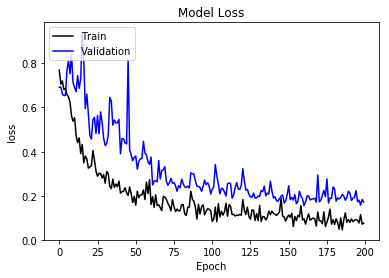

In [31]:
plt.plot(history.history['loss'], color ='black')
plt.plot(history.history['val_loss'], color = 'blue')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

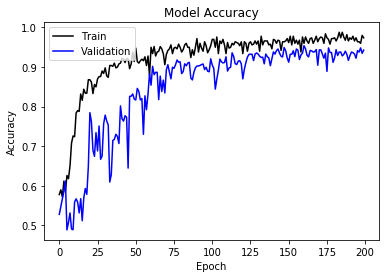

In [30]:
plt.plot(history.history['acc'], color = 'black')
plt.plot(history.history['val_acc'], color = 'blue')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
predictions = model.predict_generator(test_batches, verbose=0)

#predictions_train = model.predict_generator(train_batches, verbose = 0)

In [15]:
#images , train_labels = train_batches

In [16]:
len(predictions)

294

In [17]:
for i in range (len(predictions)):
    if predictions[i]>0.5:
        predictions[i]=1
    else:
        predictions[i]=0
        

In [18]:
print(predictions)

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.

In [19]:
#test_labels = [0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,1,0,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,1,0,1]

In [20]:
import math

#test_imgs, test_labels = test_batches

#test_imgs, test_labels = test_batches
number_of_examples = len(test_batches.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 10)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_batches[i][1]))
cm = confusion_matrix(test_labels, predictions[:,0])

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[145   1]
 [ 10 138]]


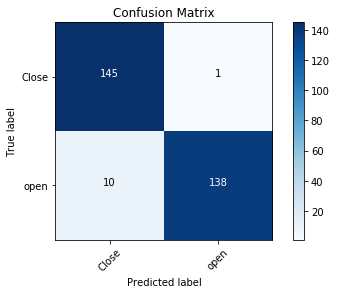

In [22]:
cm_plot_labels = ['Close','open']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [23]:
recall = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1])
precision = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[1,0])
print(recall)
print(precision)

0.9964788732394366
0.9658703071672355


In [24]:
len(test_labels)

294

In [25]:
def acc(labels,preds):
    num = 0 
    for i in range(len(preds)):
        if labels[i]==preds[i]:
            num+=1
    return num/len(preds)

In [26]:
acc(test_labels,predictions)

0.9625850340136054

In [27]:
model.save('drowsyv4.hd5')